<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import tagui as t
import pandas as pd
import numpy as np

from IPython.display import display
from PIL import Image

import imgkit

In [2]:
# Step 1
t.init()

True

In [4]:
def wait_for_pageload(selector):
    wait_status = 0
    for loop_wait in range(1, 60):
        print(f"{loop_wait}. waiting for page to appear. wait for 1s...")
        if t.present(selector):
            wait_status = 1
            break
        else:
            t.wait(1)
    print("Covid wait_status = {}".format(wait_status))

In [31]:
from goose3 import Goose
from collections import Counter
from math import fabs
import re

stopWords = {
    "-", " ", ",", ".", "a", "e", "i", "o", "u", "t", "about", "above",
    "above", "across", "after", "afterwards", "again", "against", "all",
    "almost", "alone", "along", "already", "also", "although", "always",
    "am", "among", "amongst", "amoungst", "amount", "an", "and",
    "another", "any", "anyhow", "anyone", "anything", "anyway",
    "anywhere", "are", "around", "as", "at", "back", "be", "became",
    "because", "become", "becomes", "becoming", "been", "before",
    "beforehand", "behind", "being", "below", "beside", "besides",
    "between", "beyond", "both", "bottom", "but", "by", "call", "can",
    "cannot", "can't", "co", "con", "could", "couldn't", "de",
    "describe", "detail", "did", "do", "done", "down", "due", "during",
    "each", "eg", "eight", "either", "eleven", "else", "elsewhere",
    "empty", "enough", "etc", "even", "ever", "every", "everyone",
    "everything", "everywhere", "except", "few", "fifteen", "fifty",
    "fill", "find", "fire", "first", "five", "for", "former",
    "formerly", "forty", "found", "four", "from", "front", "full",
    "further", "get", "give", "go", "got", "had", "has", "hasnt",
    "have", "he", "hence", "her", "here", "hereafter", "hereby",
    "herein", "hereupon", "hers", "herself", "him", "himself", "his",
    "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed",
    "into", "is", "it", "its", "it's", "itself", "just", "keep", "last",
    "latter", "latterly", "least", "less", "like", "ltd", "made", "make",
    "many", "may", "me", "meanwhile", "might", "mill", "mine", "more",
    "moreover", "most", "mostly", "move", "much", "must", "my", "myself",
    "name", "namely", "neither", "never", "nevertheless", "new", "next",
    "nine", "no", "nobody", "none", "noone", "nor", "not", "nothing",
    "now", "nowhere", "of", "off", "often", "on", "once", "one", "only",
    "onto", "or", "other", "others", "otherwise", "our", "ours",
    "ourselves", "out", "over", "own", "part", "people", "per",
    "perhaps", "please", "put", "rather", "re", "said", "same", "see",
    "seem", "seemed", "seeming", "seems", "several", "she", "should",
    "show", "side", "since", "sincere", "six", "sixty", "so", "some",
    "somehow", "someone", "something", "sometime", "sometimes",
    "somewhere", "still", "such", "take", "ten", "than", "that", "the",
    "their", "them", "themselves", "then", "thence", "there",
    "thereafter", "thereby", "therefore", "therein", "thereupon",
    "these", "they", "thickv", "thin", "third", "this", "those",
    "though", "three", "through", "throughout", "thru", "thus", "to",
    "together", "too", "top", "toward", "towards", "twelve", "twenty",
    "two", "un", "under", "until", "up", "upon", "us", "use", "very",
    "via", "want", "was", "we", "well", "were", "what", "whatever",
    "when", "whence", "whenever", "where", "whereafter", "whereas",
    "whereby", "wherein", "whereupon", "wherever", "whether", "which",
    "while", "whither", "who", "whoever", "whole", "whom", "whose",
    "why", "will", "with", "within", "without", "would", "yet", "you",
    "your", "yours", "yourself", "yourselves", "the", "reuters", "news",
    "monday", "tuesday", "wednesday", "thursday", "friday", "saturday",
    "sunday", "mon", "tue", "wed", "thu", "fri", "sat", "sun",
    "rappler", "rapplercom", "inquirer", "yahoo", "home", "sports",
    "1", "10", "2012", "sa", "says", "tweet", "pm", "home", "homepage",
    "sports", "section", "newsinfo", "stories", "story", "photo",
    "2013", "na", "ng", "ang", "year", "years", "percent", "ko", "ako",
    "yung", "yun", "2", "3", "4", "5", "6", "7", "8", "9", "0", "time",
    "january", "february", "march", "april", "may", "june", "july",
    "august", "september", "october", "november", "december",
    "government", "police"
}
ideal = 20.0


def SummarizeUrl(url):
    try:
        article = grab_link(url)
    except IOError:
        print('IOError')
        return None

    if not (article and article.cleaned_text and article.title):
        return None

    return Summarize(article.title, article.cleaned_text)


def Summarize(title, text):
    sentences = split_sentences(text)
    keys = keywords(text)
    titleWords = split_words(title)

    if len(sentences) <= 5:
        return sentences

    #score setences, and use the top 5 sentences
    sentence_ranks = score(sentences, titleWords, keys)
    return [sentence for sentence, score in sentence_ranks.most_common(5)]

goose = Goose()
def grab_link(url):
    #extract article information using Python Goose
    try:
        article = goose.extract(url=url)
        return article
    except ValueError:
        print('Goose failed to extract article from url')
        return None
    return None


def score(sentences, titleWords, keywords):
    #score sentences based on different features

    senSize = len(sentences)
    ranks = Counter()
    for i, s in enumerate(sentences):
        sentence = split_words(s)
        titleFeature = title_score(titleWords, sentence)
        sentenceLength = length_score(sentence)
        sentencePosition = sentence_position(i+1, senSize)
        sbsFeature = sbs(sentence, keywords)
        dbsFeature = dbs(sentence, keywords)
        frequency = (sbsFeature + dbsFeature) / 2.0 * 10.0

        #weighted average of scores from four categories
        totalScore = (titleFeature*1.5 + frequency*2.0 +
                      sentenceLength*1.0 + sentencePosition*1.0) / 4.0
        ranks[s] = totalScore
    return ranks


def sbs(words, keywords):
    score = 0.0
    if len(words) == 0:
        return 0
    for word in words:
        if word in keywords:
            score += keywords[word]
    return (1.0 / fabs(len(words)) * score)/10.0


def dbs(words, keywords):
    if (len(words) == 0):
        return 0

    summ = 0
    first = []
    second = []

    for i, word in enumerate(words):
        if word in keywords:
            score = keywords[word]
            if first == []:
                first = [i, score]
            else:
                second = first
                first = [i, score]
                dif = first[0] - second[0]
                summ += (first[1]*second[1]) / (dif ** 2)

    # number of intersections
    k = len(set(keywords.keys()).intersection(set(words))) + 1
    return (1/(k*(k+1.0))*summ)


def split_words(text):
    #split a string into array of words
    try:
        text = re.sub(r'[^\w ]', '', text)  # strip special chars
        return [x.strip('.').lower() for x in text.split()]
    except TypeError:
        print("Error while splitting characters")
        return None


def keywords(text):
    """get the top 10 keywords and their frequency scores
    ignores blacklisted words in stopWords,
    counts the number of occurrences of each word
    """
    text = split_words(text)
    numWords = len(text)  # of words before removing blacklist words
    freq = Counter(x for x in text if x not in stopWords)

    minSize = min(10, len(freq))  # get first 10
    keywords = {x: y for x, y in freq.most_common(minSize)}  # recreate a dict

    for k in keywords:
        articleScore = keywords[k]*1.0 / numWords
        keywords[k] = articleScore * 1.5 + 1

    return keywords


def split_sentences(text):
    '''
    The regular expression matches all sentence ending punctuation and splits the string at those points.
    At this point in the code, the list looks like this ["Hello, world", "!" ... ]. The punctuation and all quotation marks
    are separated from the actual text. The first s_iter line turns each group of two items in the list into a tuple,
    excluding the last item in the list (the last item in the list does not need to have this performed on it). Then,
    the second s_iter line combines each tuple in the list into a single item and removes any whitespace at the beginning
    of the line. Now, the s_iter list is formatted correctly but it is missing the last item of the sentences list. The
    second to last line adds this item to the s_iter list and the last line returns the full list.
    '''
    
    sentences = re.split('(?<![A-ZА-ЯЁ])([.!?]"?)(?=\s+\"?[A-ZА-ЯЁ])', text)
    s_iter = list(zip(*[iter(sentences[:-1])] * 2))
    s_iter = [''.join(map(str,y)).lstrip() for y in s_iter]
    s_iter.append(sentences[-1])
    return s_iter



def length_score(sentence):
    return 1 - fabs(ideal - len(sentence)) / ideal


def title_score(title, sentence):
    title = [x for x in title if x not in stopWords]
    count = 0.0
    for word in sentence:
        if (word not in stopWords and word in title):
            count += 1.0
            
    if len(title) == 0:
        return 0.0
        
    return count/len(title)


def sentence_position(i, size):
    """different sentence positions indicate different
    probability of being an important sentence"""

    normalized = i*1.0 / size
    if 0 < normalized <= 0.1:
        return 0.17
    elif 0.1 < normalized <= 0.2:
        return 0.23
    elif 0.2 < normalized <= 0.3:
        return 0.14
    elif 0.3 < normalized <= 0.4:
        return 0.08
    elif 0.4 < normalized <= 0.5:
        return 0.05
    elif 0.5 < normalized <= 0.6:
        return 0.04
    elif 0.6 < normalized <= 0.7:
        return 0.06
    elif 0.7 < normalized <= 0.8:
        return 0.04
    elif 0.8 < normalized <= 0.9:
        return 0.04
    elif 0.9 < normalized <= 1.0:
        return 0.15
    else:
        return 0

In [32]:
# go to the news website
t.url('https://www.who.int/emergencies/diseases/novel-coronavirus-2019/media-resources/news')

wait_for_pageload('//p[@class="heading text-underline"]')

num_news = t.count('//p[@class="heading text-underline"]') 
if num_news > 5:
    num_news = 5

for n in range(1, num_news+1):
    news_link = t.read(f'(//p[@class="heading text-underline"])[{n}]/ancestor-or-self::a/@href')
    news_title = t.read(f'(//p[@class="heading text-underline"])[{n}]/ancestor-or-self::a/@aria-label')
    print('Article', n, ":", news_title)
    print('')
    news_summaries = SummarizeUrl(news_link)
    print(news_summaries)
#     for sentence in summaries:
#         print(sentence)
#         print('')
    print('-'*20)

[RPA][ERROR] - no active TagUI process to send()
1. waiting for page to appear. wait for 1s...
[RPA][ERROR] - use init() before using present()
2. waiting for page to appear. wait for 1s...
[RPA][ERROR] - use init() before using present()
3. waiting for page to appear. wait for 1s...
[RPA][ERROR] - use init() before using present()
4. waiting for page to appear. wait for 1s...
[RPA][ERROR] - use init() before using present()
5. waiting for page to appear. wait for 1s...
[RPA][ERROR] - use init() before using present()
6. waiting for page to appear. wait for 1s...
[RPA][ERROR] - use init() before using present()
7. waiting for page to appear. wait for 1s...
[RPA][ERROR] - use init() before using present()
8. waiting for page to appear. wait for 1s...
[RPA][ERROR] - use init() before using present()
9. waiting for page to appear. wait for 1s...
[RPA][ERROR] - use init() before using present()
10. waiting for page to appear. wait for 1s...
[RPA][ERROR] - use init() before using present()


KeyboardInterrupt: 

In [5]:
# go to the website
t.url('https://www.worldometers.info/coronavirus/')

wait_for_pageload('//div[@class="maincounter-number"]')
global_case = t.read('(//div[@class="maincounter-number"])[1]/span')
global_death = t.read('(//div[@class="maincounter-number"])[2]/span')
global_recovered = t.read('(//div[@class="maincounter-number"])[3]/span')

print("global confirmed cases number: " + global_case)
print("global death number: " + global_death)
print("global recovered number: " + global_recovered)

1. waiting for page to appear. wait for 1s...
Covid wait_status = 1
global confirmed cases number: 3,244,537
global death number: 229,179
global recovered number: 1,016,321


In [6]:
# country search data
# if by search (no need)
# t.type('(//input[@type="search"])[1]', country_input)

country_input = 'USA'

country_row_xpath = f'(//a[@class="mt_a" and text()="{country_input}"])[1]'

country_link_xpath = country_row_xpath + '/@href'
country_total_cases_xpath = country_row_xpath + '/../following-sibling::td[1]'
country_new_cases_xpath = country_row_xpath + '/../following-sibling::td[2]'
country_total_deaths_xpath = country_row_xpath + '/../following-sibling::td[3]'
country_new_deaths_xpath = country_row_xpath + '/../following-sibling::td[4]'
country_total_recovered_xpath = country_row_xpath + '/../following-sibling::td[5]'
country_active_cases_xpath = country_row_xpath + '/../following-sibling::td[6]'
country_serious_cases_xpath = country_row_xpath + '/../following-sibling::td[7]'

country_link = 'https://www.worldometers.info/coronavirus/' + t.read(country_link_xpath)
country_total_cases = t.read(country_total_cases_xpath)
country_new_cases = t.read(country_new_cases_xpath)
country_total_deaths = t.read(country_total_deaths_xpath)
country_new_deaths = t.read(country_new_deaths_xpath)
country_total_recovered = t.read(country_total_recovered_xpath)
country_active_cases = t.read(country_active_cases_xpath)
country_serious_cases = t.read(country_serious_cases_xpath)

print("total_cases: " + country_total_cases)
print("new_cases: " + country_new_cases)
print("total_deaths: " + country_total_deaths)
print("new_deaths: " + country_new_deaths)
print("total_recovered: " + country_total_recovered)
print("active_cases: " + country_active_cases)
print("serious_cases: " + country_serious_cases)
print("link: " + country_link)

total_cases: 1,064,832
new_cases: +638
total_deaths: 61,680
new_deaths: +24
total_recovered: 147,473
active_cases: 855,679
serious_cases: 18,851
link: https://www.worldometers.info/coronavirus/country/us/


In [9]:
# all countries data (database preparation)
num_country = int(t.count('(//a[@class="mt_a"])')/2) # first half is for today, second half is for yesterday
# num_country = 3 # testing
data_country = []
col_country = ['No','Country','Total Cases', 'New Cases', 'Total Deaths', 
               'New Deaths', 'Total Recovered', 'Active Cases', 'Serious Cases', 'Link']

for n in range(1, num_country+1):
    country_row_xpath = f'(//a[@class="mt_a"])[{n}]'
    
    country_link_xpath = country_row_xpath + '/@href'
    country_total_cases_xpath = country_row_xpath + '/../following-sibling::td[1]'
    country_new_cases_xpath = country_row_xpath + '/../following-sibling::td[2]'
    country_total_deaths_xpath = country_row_xpath + '/../following-sibling::td[3]'
    country_new_deaths_xpath = country_row_xpath + '/../following-sibling::td[4]'
    country_total_recovered_xpath = country_row_xpath + '/../following-sibling::td[5]'
    country_active_cases_xpath = country_row_xpath + '/../following-sibling::td[6]'
    country_serious_cases_xpath = country_row_xpath + '/../following-sibling::td[7]'
    
    country_link = 'https://www.worldometers.info/coronavirus/' + t.read(country_link_xpath)
    country_total_cases = t.read(country_total_cases_xpath)
    country_new_cases = t.read(country_new_cases_xpath)
    country_total_deaths = t.read(country_total_deaths_xpath)
    country_new_deaths = t.read(country_new_deaths_xpath)
    country_total_recovered = t.read(country_total_recovered_xpath)
    country_active_cases = t.read(country_active_cases_xpath)
    country_serious_cases = t.read(country_serious_cases_xpath)
    
    country_name = t.read(country_row_xpath)
    
    print("n =", n)
    print("country_name:", country_name)
    print("total_cases:", country_total_cases)
    print("new_cases:", country_new_cases)
    print("total_deaths:", country_total_deaths)
    print("new_deaths:", country_new_deaths)
    print("total_recovered:", country_total_recovered)
    print("active_cases:", country_active_cases)
    print("serious_cases:", country_serious_cases)
    print("link:", country_link)
    
    print("-"*20)

    data_country.append([n, country_name, country_total_cases, 
                         country_new_cases, country_total_deaths, country_new_deaths, 
                         country_total_recovered, country_active_cases, country_serious_cases,
                         country_link])
    df_country  = pd.DataFrame(data_country, columns = col_country)

n = 1
country_name: USA
total_cases: 1,064,832
new_cases: +638
total_deaths: 61,680
new_deaths: +24
total_recovered: 147,473
active_cases: 855,679
serious_cases: 18,851
link: https://www.worldometers.info/coronavirus/country/us/
--------------------
n = 2
country_name: Spain
total_cases: 239,639
new_cases: +2,740
total_deaths: 24,543
new_deaths: +268
total_recovered: 137,984
active_cases: 77,112
serious_cases: 2,676
link: https://www.worldometers.info/coronavirus/country/spain/
--------------------
n = 3
country_name: Italy
total_cases: 203,591
new_cases: 
total_deaths: 27,682
new_deaths: 
total_recovered: 71,252
active_cases: 104,657
serious_cases: 1,795
link: https://www.worldometers.info/coronavirus/country/italy/
--------------------


In [8]:
df_country

,No,Country,Total Cases,New Cases,Total Deaths,New Deaths,Total Recovered,Active Cases,Serious Cases,Link
0,1,USA,"1,064,832",+638,"61,680",+24,"147,473","855,679","18,851",https://www.worldometers.info/coronavirus/coun...
1,2,Spain,"239,639","+2,740","24,543",+268,"137,984","77,112","2,676",https://www.worldometers.info/coronavirus/coun...
2,3,Italy,"203,591",,"27,682",,"71,252","104,657","1,795",https://www.worldometers.info/coronavirus/coun...


In [41]:
# save to csv
df_country.to_csv('covid_country.csv', index=False)

In [ ]:
# extract html element for the whole page
html_element = t.read('page')
t.dump(html_element, 'whole.html')

# TODO extract svg element data


In [42]:
# save html to image file
options = {
    'format': 'png',
    'crop-h': '400',
    'crop-w': '350',
    'crop-x': '3',
    'crop-y': '3',
    'encoding': "UTF-8"
}

imgkit.from_file('xx.html', 'out_test.jpg', options=options)

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


True

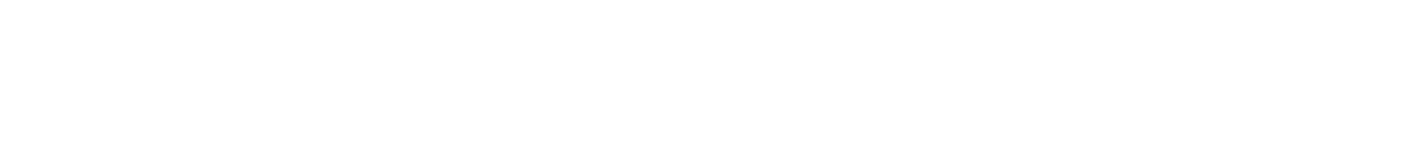

In [44]:
global_case_chart = '(//*[name()="svg"]/*[name()="rect" and @class="highcharts-background"])[3]/../../..'
test = '(//div[@class="maincounter-number"])[1]'

# t.snap(global_case_chart, 'test.png')

us = '/html/body/div[3]/div[2]/div[1]/div/div[6]/div/span'
t.snap(test, 'test.png')
display(Image.open('test.png'))

In [10]:
t.close()

True